In [1]:
import os
import sys

import itertools
import pickle
import imageio
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

sys.path.append('../')
import utils
%matplotlib inline

In [2]:
if not os.path.isdir('MNIST_GAN_results'):
    os.mkdir('MNIST_GAN_results')
if not os.path.isdir('MNIST_GAN_results/Random_results'):
    os.mkdir('MNIST_GAN_results/Random_results')
if not os.path.isdir('MNIST_GAN_results/Fixed_results'):
    os.mkdir('MNIST_GAN_results/Fixed_results')

In [3]:
lr = 0.0002
prior_size = 100
batch_size = 256
train_epoch = 1000

In [4]:
normalize = ((0.5,), (0.5,))
train_loader = utils.loader(batch_size=batch_size, train=True, normalize=normalize, path='../dataset')
test_loader = utils.loader(batch_size=batch_size, train=False, normalize=normalize, path='../dataset')

In [5]:
def show_result(num_epoch, prior_size, show=False, save=False, path='result.png', isFix=False):
    z_prior = torch.randn((5*5, prior_size))
    z_prior = Variable(z_prior, volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z)
    else:
        test_images = G(z_prior)
        
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [6]:
class generator(nn.Module):
    def __init__(self, input_size=10,):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, 28*28)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        
        return x

In [7]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc4(x)

        return x

In [8]:
fixed_z = torch.randn((5 * 5, prior_size))    # fixed noise
fixed_z = Variable(fixed_z, volatile=True)

# network
G = generator(input_size=prior_size)
D = discriminator()

# Binary Cross Entropy loss
BCE_loss = nn.BCEWithLogitsLoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

[1/1000]: loss_d: 0.428, loss_g: 1.308


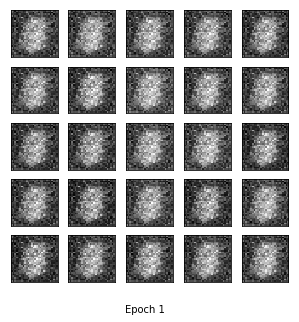

In [ ]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    for x, _ in train_loader:
        # train discriminator D
        D.zero_grad()
        G.zero_grad()

        x = x.view(-1, 28 * 28)

        mini_batch = x.size()[0]
        z_prior = torch.randn((mini_batch, prior_size))

        y_real = torch.ones(mini_batch, 1)
        y_fake = torch.zeros(mini_batch, 1)

        x, y_real, y_fake = Variable(x), Variable(y_real), Variable(y_fake)
        z_prior = Variable(z_prior)
        
        D_real_loss = BCE_loss(D(x), y_real)
        D_fake_loss = BCE_loss(D(G(z_prior)), y_fake)

        D_train_loss = (D_real_loss + D_fake_loss)*0.5

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.cpu().data[0])

        # train generator G
        D.zero_grad()
        G.zero_grad()

        z_prior = torch.randn((mini_batch, prior_size))
        z_prior = Variable(z_prior)
        
        G_train_loss = BCE_loss(D(G(z_prior)), y_real)
        # G_train_loss = BCE_loss(1-D(G(z_prior)), y_fake)
        
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        (epoch + 1), train_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), prior_size=prior_size, save=True, path=p, isFix=False)
    show_result((epoch+1), prior_size=prior_size, save=True, show=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))


print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_GAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_GAN_results/discriminator_param.pkl")
with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

